# H/W Part 3

Данные взяты с www.kaggle.com/datasets/mohannapd/mobile-price-prediction 

Коротко о данных: датасет содержит информацию о характеристиках мобильных устройств (обезличенных), основный акцент делается на цене (автором датасет предлагается для изучения регрессии)

Изначально я начинал делать Д/З на других данных, но кластеризация проходила очень плохо, поэтому подобрал датасет в такой же тематике но с другими значениями; главное отличие - цена количественная, а не категориальная переменная 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition# Start writing code here...

In [ ]:
data = pd.read_csv("Cellphone.csv")
df = data

## Basic EDA

Общая информация о датасете + количество нулей

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_id    161 non-null    int64  
 1   Price         161 non-null    int64  
 2   Sale          161 non-null    int64  
 3   weight        161 non-null    float64
 4   resoloution   161 non-null    float64
 5   ppi           161 non-null    int64  
 6   cpu core      161 non-null    int64  
 7   cpu freq      161 non-null    float64
 8   internal mem  161 non-null    float64
 9   ram           161 non-null    float64
 10  RearCam       161 non-null    float64
 11  Front_Cam     161 non-null    float64
 12  battery       161 non-null    int64  
 13  thickness     161 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 17.7 KB


Сколько у нас missing values?

- Отлично

In [ ]:
df.head()

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


In [ ]:
df.describe()

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,675.559006,2215.596273,621.465839,170.426087,5.209938,335.055901,4.857143,1.502832,24.501714,2.204994,10.378261,4.503106,2842.111801,8.921739
std,410.851583,768.187171,1546.618517,92.888612,1.509953,134.826659,2.444016,0.599783,28.804773,1.609831,6.181585,4.342053,1366.990838,2.192564
min,10.000000,614.000000,10.000000,66.000000,1.400000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,800.000000,5.100000
25%,237.000000,1734.000000,37.000000,134.100000,4.800000,233.000000,4.000000,1.200000,8.000000,1.000000,5.000000,0.000000,2040.000000,7.600000
50%,774.000000,2258.000000,106.000000,153.000000,5.150000,294.000000,4.000000,1.400000,16.000000,2.000000,12.000000,5.000000,2800.000000,8.400000
75%,1026.000000,2744.000000,382.000000,170.000000,5.500000,428.000000,8.000000,1.875000,32.000000,3.000000,16.000000,8.000000,3240.000000,9.800000
max,1339.000000,4361.000000,9807.000000,753.000000,12.200000,806.000000,8.000000,2.700000,128.000000,6.000000,23.000000,20.000000,9500.000000,18.500000


Можно заметить, что датасет содержит 14 переменных, однако, использовать их все в кластеризации будет излишним. 

## Clusterization

### Preprocessing

Согласно статье Research on Comprehensive Clustering for Smart Phone Configuration цена является одним из важных факторов кластеризации. Это достаточно тривиальное умозаключение, но проговорить стоит: цена сильно зависит от технических характеристик мобильных устройств, и, скорее всего, зависимость положительно-линейная. 

Я ставлю перед собой две задачи (1 - основная, 2 - дополнительная):

- Разбить телефоны на группы, т.к. для каждой группы понадобится отдельный подход в рекламной компании (advertisement)

- Сравнить кластеризацию мобильных устройств с ценой и без нее

Для начала, я отберу необходимые переменные из всего датасета:

Цена (price), размер (resolution), характеристики центрального процесса (CPU frequency & core) были указаны в статье как влиятельные факторы; дополнительно я решил взять объем батареи и толщину смартфона как переменные, также влияющие на желание покупателя приобрести телефон

In [ ]:
df_cl = df[["Price","resoloution", "thickness", "cpu freq", "cpu core", "battery"]]
df_cl

# также я пробовал "ppi" вместо толщины - Phone Pixel Density - но kmodel.inertia_ был значительно выше 

,Price,resoloution,thickness,cpu freq,cpu core,battery
0,2357,5.20,7.4,1.350,8,2610
1,1749,4.00,9.9,1.300,2,1700
2,1916,4.70,7.6,1.200,4,2000
3,1315,4.00,11.0,1.300,2,1400
4,1749,4.00,9.9,1.300,2,1700
...,...,...,...,...,...,...
156,3551,5.46,8.4,1.875,4,4080
157,3211,5.50,7.9,1.975,4,3400
158,3260,5.50,6.8,2.200,8,3000
159,3211,5.50,7.9,1.975,4,3400


Переименуем для удобства некоторые переменные

In [ ]:
df_cl.columns = ["price", "resolution", "thickness", "CPU_freq", "CPU_core", "battery"]
df_cl
#thickness 

,price,resoloution,thickness,CPU_freq,CPU_core,battery
0,2357,5.20,7.4,1.350,8,2610
1,1749,4.00,9.9,1.300,2,1700
2,1916,4.70,7.6,1.200,4,2000
3,1315,4.00,11.0,1.300,2,1400
4,1749,4.00,9.9,1.300,2,1700
...,...,...,...,...,...,...
156,3551,5.46,8.4,1.875,4,4080
157,3211,5.50,7.9,1.975,4,3400
158,3260,5.50,6.8,2.200,8,3000
159,3211,5.50,7.9,1.975,4,3400


Обязательный шаг - стандартизация переменных. Думаю, объяснять не стоит

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_df = scaler.fit_transform(df_cl)
scaled_df[0:5]

array([[ 0.18464891, -0.00660212, -0.69621099, -0.25560783,  1.28995197,
        -0.17032742],
       [-0.60929437, -0.80380849,  0.44756421, -0.33923146, -1.17268361,
        -0.83810023],
       [-0.39122113, -0.33877144, -0.60470897, -0.50647872, -0.35180508,
        -0.61795535],
       [-1.17602361, -0.80380849,  0.95082529, -0.33923146, -1.17268361,
        -1.05824512],
       [-0.60929437, -0.80380849,  0.44756421, -0.33923146, -1.17268361,
        -0.83810023]])

Наконец я выделю отдельные данные для кластеризации без влияния ценника устройства - для выполнения задачи b

In [ ]:
df_cl_priceless = df[["resoloution", "cpu freq", "cpu core", "battery", "thickness"]]
df_cl_priceless.columns = ["resoloution", "CPU_freq", "CPU_core", "battery", "thickness"]
scaled_df_priceless = scaler.fit_transform(df_cl_priceless)

In [ ]:
## scaled_df_priceless = scaled_df.drop(columns = "price") 
## К сожалению, данный способ не работает! А это сократило бы предыдущий чанк на 3 больших строки

### Performing (KMEANS)

Итак, давайте приступим к выполнению кластеризации. Для начала, в методе kmeans, необходимо вычислить оптимальное N кластеров. Сделаем это с помощью графика силуэта

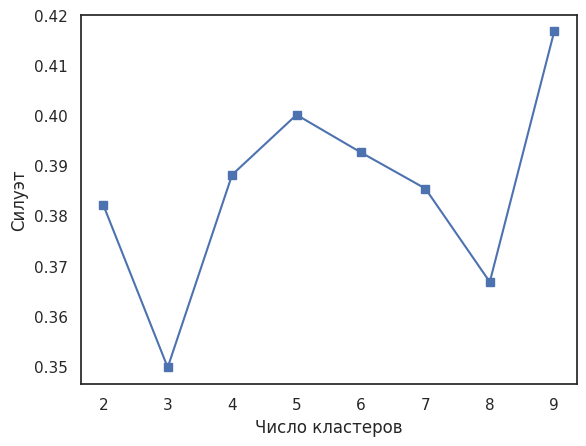

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans

sil = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(scaled_df)
    sil.append(metrics.silhouette_score(scaled_df, kmeans.labels_))

plt.plot(range(2, 10), sil, marker='s');
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт');

Кратко: Чем ближе к 1, тем лучше. 

Самый высокий показатель - 9, однако такое число будет излишним - получившиеся кластеры будет тяжело проинтерпретировать и отделить друг от друга - тем более, из-за не слишком большого изначального N, датасет поделится на очень маленькие группы. Поэтому мы берем 5, как второе наиближайшее к 1 число

In [ ]:
kmodel = KMeans(n_clusters = 5, random_state = 228)
kmodel.fit(scaled_df)

res = df_cl.copy()
res["cluster"] = kmodel.labels_
res.groupby("cluster").mean()

## all_predictions_scaled = kmodel_scaled.predict(scaled_df)
## all_predictions_scaled


,price,resoloution,thickness,CPU_freq,CPU_core,battery
cluster,,,,,,
0,1727.796610,5.118983,9.335593,1.220339,3.525424,2387.288136
1,2731.882353,5.352353,8.511765,2.176765,4.000000,3090.000000
2,2307.500000,11.150000,7.900000,1.930000,6.000000,8450.000000
3,720.833333,2.016667,14.450000,0.034667,0.166667,900.000000
4,2769.365385,5.500000,7.523077,1.688654,7.923077,3212.884615


Итак, давайте охарактеризуем получившиеся кластеры:

- Кластер с наибольшим числом значений в датасете - как и ожидается от массовости, данная линейка смартфонов обладает средними характеристиками - не плохими но и не наилучшими. Батарейка, частота процессора и размер экрана отстает от более дорогих аналогов (кластеры 1, 4), но и гораздо лучше чем 3 дешевый кластер. Тренд продолжается и в относительно не дорогой средней цене на подобные телефоны. Этот сегмент стоит ориентировать на типичного массового потребителя, который не готов разбрасываться деньгами, но хочет иметь актуальный, не отстающий от трендов телефон. Назовем кластер "Mass Production"

- Один из двух дорогих кластеров с мощнейшими характеристиками. Эту линейку смартфонов стоит рекомендовать людям, которые хотят получить быстроработающий модерновый телефон, чтобы не отставать от трендов. Естественно, стоит ориентироваться на людей, которые не будут жалеть потратить много денег на новинку. Назовем кластер "Effective Performance"

- Аномальный кластер - не смотря на то, что его цена низка по сравнению с кластерами 1, 4 средний размер (resolution) экрана в этой группе превышает более чем в 2 раза размеры с дорогих кластеров, а объем батареи - чуть ли не в 3. Это можно объяснить то, что в данную группу вошли всего лишь 4 товара. Я считаю, что не стоит разрабатывать отдельную рекламную кампанию для 4 телефонов, а их самих стоит отнести в ручную к оставшимся 4 кластерам. Назовем кластер "Anomaly"

- Самая дешевая и скудная на технические хар-ки линейка телефонов. Его стоит рекомендовать людям низшего экономического статуса или тем, кто воспринимает телефон только как средство для звонков и не хочет тратится на лучшие модели. Назовем кластер "Cheap"

- Самый дорогой кластер среди выделившихся. У него наибольшие размеры, наименьшая толщина и сильная батарейка, однако по ключевой для производительности смартфона характеристики - частота процессора - он уступает чуть более дешевому кластеру 1. Предположение: рекламная компания для него будет схожа с кластером 1, однако стоит делать упор на более изящный вид (высокий и тонкий экран) в продаже, вполне возможно что он подойдет типичным инстаграм-моделям, не сильно разбирающимся в технических хар-ках, но желающим носить более стильный смартфон. Назовем кластер "Show-off"

In [ ]:
res['cluster'].value_counts()

0    59
4    52
1    34
3    12
2     4
Name: cluster, dtype: int64

In [ ]:
kmodel.inertia_

243.68003676996975

Данный показатель очень неплох по сравнению с вариантами, которые я тестил раньше

In [ ]:
kmodel_priceless = KMeans(n_clusters = 5, random_state = 228)
kmodel_priceless.fit(scaled_df_priceless)

res = df_cl.copy() # присоединяем кластеры сформированные без учета цены к изначальному датафрейму где сть цена 
res["cluster"] = kmodel_priceless.labels_
res.groupby("cluster").mean()


,price,resoloution,thickness,CPU_freq,CPU_core,battery
cluster,,,,,,
0,2517.826087,5.716957,8.665217,1.945000,4.000000,3262.608696
1,720.833333,2.016667,14.450000,0.034667,0.166667,900.000000
2,1727.591837,4.735102,9.391837,1.216327,3.510204,2098.571429
3,2767.180000,5.500000,7.452000,1.695000,8.000000,3201.400000
4,2307.500000,11.150000,7.900000,1.930000,6.000000,8450.000000


In [ ]:
res['cluster'].value_counts()

3    50
2    49
0    46
1    12
4     4
Name: cluster, dtype: int64

In [ ]:
kmodel_priceless.inertia_

193.86534423401977

Кратко пробежавшись глазами по характеристикам кластеров, созданных без учета цены телефона можно заметить огромное количество схожестей с предыдущими группами; в целом кластеризация с таким же seed (random_state) не значительно отличается от предыдущей. 

Сравним схожесть двух разных кластеризаций одной и той же выборки с помощью команды ниже:

In [ ]:
metrics.adjusted_rand_score(kmodel.labels_, kmodel_priceless.labels_)

0.8034322420631351

Значение достаточно близко к 1, а значит можно с уверенностью сказать, что мы получили два не значительно различающихся разбиения. Тем не менее, разница в 0.2 единицы говорит о высокой важности параметра цены. Я могу предположить, что если бы мы исключали любую другую переменную, разница была бы гораздо меньше

### Performing (DBSCAN)

Теперь можно попробовать другой метод, который, как говорят, является более надежным по сравнению с kmeans

In [ ]:
from sklearn.cluster import DBSCAN

dbmodel = DBSCAN(eps=0.5, min_samples=5)
dbmodel = dbmodel.fit(scaled_df)
dbpred = dbmodel.labels_
res = df_cl.copy()
res["cluster"] = dbmodel.labels_
res.groupby("cluster").mean()

,price,resoloution,thickness,CPU_freq,CPU_core,battery
cluster,,,,,,
-1,2128.553191,5.235106,9.238298,1.357404,4.787234,2979.574468
0,2338.600000,5.120000,7.680000,1.430000,8.000000,2602.000000
1,1782.875000,4.856250,8.450000,1.231250,4.000000,2103.125000
2,1285.000000,4.000000,11.100000,1.233333,2.000000,1486.666667
3,2385.857143,5.200000,8.900000,2.442857,4.000000,2728.571429
4,2944.500000,5.566667,7.966667,1.884167,4.000000,3425.000000
5,2854.428571,5.700000,7.685714,1.664286,8.000000,3044.285714


In [ ]:
res['cluster'].value_counts()

-1    94
 1    16
 3    14
 5    14
 4    12
 2     6
 0     5
Name: cluster, dtype: int64

DBSCAN произвел большее число кластеров, однако абсолютное большинство отнес к "шуму" (-1 группа). Если увеличивать параметр "eps", кластеров будет меньше, но и различий между ними также сведутся к, по сути, одной лишь цене. Провести рекламную компанию опираясь только на цену можно было и без кластеризации

Как по мне, kmeans показал себя лучшим образом - мы успешно смогли выделить группы, отличающиеся по смыслу и по многим хар-кам между собой, в то время как DBSCAN относит большинство переменных к "шуму"; из такой кластеризации нельзя вывести какие-либо значимые инсайты

In [ ]:
metrics.adjusted_rand_score(kmodel.labels_, dbmodel.labels_)

0.11524723141433811

## Subgroups

Логично, что задача на подгруппы будет отличаться от задачи на простую кластеризацию

Нас, как владельца магазина (будем считать что этот датасет собран из покупок в нашем онлайн-ритейл магазине за неделю) будет интересовать, какие телефоны лучше всего продаются. На телефоны с *такими* характеристиками нам и нужно будет сделать упор и увеличить количество товара.

In [ ]:
!pip install pysubgroup
import pysubgroup as ps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 5.3 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


Немного преобразим датасет для этой задачи: а именно, прибавим показатель "sale" к сформированному для задач кластеризации датафрейму

In [ ]:
df_sub = df[["Price", "Sale", "resoloution", "thickness", "cpu freq", "cpu core", "battery"]]
df_sub.columns = ["price", "sale", "resolution", "thickness", "CPU_freq", "CPU_core", "battery"]

Естественно, целевой переменной здесь являются продажи, как наиболее интересующая потенциального хозяина параметр

In [ ]:
target = ps.NumericTarget("sale")

searchspace = ps.create_selectors(df_sub, ignore=['sale'])

task = ps.SubgroupDiscoveryTask (
    df_sub,
    target,
    searchspace,
    result_set_size=5,
    depth=2,
    qf=ps.StandardQFNumeric(a = 0.5)
)

Для анализа используем StandardQFNumeric - взвешенную характеристику, определяющую баланс между размером группы и ее отличием от среднего (для количественных данных)

In [ ]:
result = ps.BeamSearch().execute(task)
result.to_dataframe()

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,9317.568323,resolution: [5.50:5.70[ AND thickness: [7.50:8.0[,4.0,161.0,5280.250000,621.465839,3217.599911,1541.807873,5052.0,106.0,8946.0,9807.0,2071.0,10.0,8.496444,47.660377
1,7059.419052,price>=2859 AND resolution: [5.50:5.70[,15.0,161.0,2444.200000,621.465839,3178.261730,1541.807873,996.0,106.0,8946.0,9807.0,19.0,10.0,3.932960,9.396226
2,6871.333177,battery: [3000:3430[ AND resolution: [5.50:5.70[,13.0,161.0,2527.230769,621.465839,3394.234459,1541.807873,567.0,106.0,8946.0,9807.0,16.0,10.0,4.066564,5.349057
3,6693.340010,CPU_core: [4:6[ AND price>=2859,12.0,161.0,2553.666667,621.465839,3111.299309,1541.807873,1112.5,106.0,8946.0,9807.0,19.0,10.0,4.109102,10.495283
4,6264.162240,CPU_freq>=1.98 AND resolution: [5.50:5.70[,11.0,161.0,2510.181818,621.465839,3734.350688,1541.807873,367.0,106.0,8946.0,9807.0,12.0,10.0,4.039131,3.462264


Как мы можем заметить, наибольшим "качеством" обладает подгруппа, в которой разрешение телефона находится между 5.50 и 5.70, но только ВМЕСТЕ с тем, чтобы толщина экрана находилась в районе от 7.5 до 8. Не смотря на то что размер подгруппы наименьший среди выделенных (4 < 15), данное правило является наиболее осмысленным - оно затрагивает внешние характеристики смартфона, на которые часто обращают внимание на покупке. 

Люди привыкли чтобы их телефон не был слишком толстым, а экран - достаточно большим, но не с размером в "палку" (как раньше было принято называть телефоны с гигантским экраном)

Кроме того, в этом правиле наибольший lift (mean_lift + median_lift), что означает наибольший прирост в “дополнительной ценности” (от того, что они вместе) среди всех подгрупп

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=95fbf5ae-e3be-477e-8a63-7d41e19c6ba9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>